In [86]:
import PyPDF2
import nltk
import spacy
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
import string
import re
import matplotlib.pyplot as plt

In [103]:
# define the class
class EarningsAnalysis:
    def __init__(self, pdf_path: str, company_name: str, quarter: str):
        # Validate company name
        if not company_name.islower():
            raise ValueError("Company name should be in lowercase.")
        self.company_name = company_name

        # Validate quarter format
        quarter_pattern = r"^Q[1-4]\d{2}$"
        if not re.match(quarter_pattern, quarter):
            raise ValueError("Quarter should be in the format Q[1,2,3,4]YY.")
        self.quarter = quarter
        self.stopwords_custom = [self.company_name, self.quarter, "officer", "analyst", "factset"]  # Define domain-specific stopwords
        self.stopwords = stopwords.words('english') + list(string.punctuation) + self.stopwords_custom
        self.pdf_path = pdf_path # save path to be used in text extraction
        self.transcript_text = self.extract_text_from_pdf()

    def extract_text_from_pdf(self):
        """
        This method extracts text from a PDF doc into a single stream of text.
        """
        text = ""
        with open(self.pdf_path, "rb") as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text()
        return text

    def preprocess_words(self, text: str):
        """
        This method breaks down the pdf text into tokens of words.
        """
        singles_removed = re.sub(r'\s+[a-zA-Z]\s', ' ', text)
        tokens = nltk.word_tokenize(singles_removed)
        clean_tokens = [token.lower() for token in tokens if token.isalnum()]
        stop_all = self.stopwords
        stop_removal = [stop for stop in clean_tokens if stop not in stop_all]
        pos_tokens = nltk.pos_tag(stop_removal)

        lemmatizer = nltk.WordNetLemmatizer()
        stems = []
        for t in pos_tokens:
            word = t[0]
            pos_type = t[1]
            wordnet_pos = self.get_wordnet_pos(pos_type)
            stems.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
        return stop_removal, stems, pos_tokens

    def ngrams(self, tokens: list, num_ngrams: int):
        """
        This method extracts relevant keywords using n-grams.
        """
        ngrams = nltk.ngrams(tokens, num_ngrams)
        ngram_freq = nltk.FreqDist(ngrams)

        stop_all = self.stopwords
        
        keywords = [ngram for ngram in ngram_freq if ngram[0] not in stop_all and ngram[1] not in stop_all]
        return keywords, ngram_freq

    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  # Default to noun if POS tag is not recognized

    def word_frequency_dist(self, tokens: list):
        fdist = nltk.FreqDist(tokens)
        fdist.plot(30, cumulative=False, title="Top 30 Most Common Words")

    def preprocess_sentences(self, text: str):
        """
        This method breaks down the pdf text into tokens of sentences which is 
        more useful for later methods to provide context about topics discussed in the call.
        """
        #singles_removed = re.sub(r'\s+[a-zA-Z]\s', ' ', text)
        tokens = nltk.sent_tokenize(text)
        clean_tokens = [token.lower() for token in tokens if token.isalnum()]
        stop_all = stopwords.words('english') + list(string.punctuation)
        stop_removal = [stop for stop in clean_tokens if stop not in stop_all]
        pos_tokens = nltk.pos_tag(stop_removal)

        lemmatizer = nltk.WordNetLemmatizer()
        stems = []
        for t in pos_tokens:
            word = t[0]
            pos_type = t[1]
            wordnet_pos = self.get_wordnet_pos(pos_type)
            stems.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
        return stop_removal, stems, pos_tokens


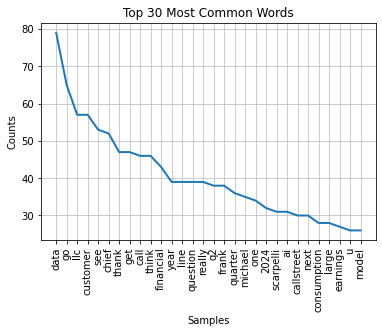

In [105]:
earnings_analysis = EarningsAnalysis("Data/SNOW_Q224.pdf", company_name='snowflake', quarter='Q224')
#snowflake = earnings_analysis.extract_text_from_pdf("Data/SNOW_Q224.pdf")
removed_stopwords, word_stems, pos_tags = earnings_analysis.preprocess_words(snowflake)
ngram_keywords, ngram_freq = earnings_analysis.ngrams(removed_stopwords, 2)
earnings_analysis.word_frequency_dist(word_stems)

In [106]:
ngram_keywords

[('scarpelli', 'chief'),
 ('chief', 'financial'),
 ('callstreet', 'llc'),
 ('michael', 'scarpelli'),
 ('2024', 'earnings'),
 ('earnings', 'call'),
 ('corrected', 'transcript'),
 ('copyright', '2001'),
 ('2001', 'callstreet'),
 ('snow', 'q2'),
 ('q2', '2024'),
 ('call', 'corrected'),
 ('frank', 'slootman'),
 ('slootman', 'chairman'),
 ('chairman', 'chief'),
 ('chief', 'executive'),
 ('line', 'open'),
 ('operator', 'thank'),
 ('question', 'line'),
 ('thank', 'next'),
 ('securities', 'llc'),
 ('next', 'question'),
 ('next', 'year'),
 ('financial', 'inc'),
 ('ladies', 'gentlemen'),
 ('fiscal', '2024'),
 ('language', 'models'),
 ('container', 'services'),
 ('thank', 'much'),
 ('supply', 'chain'),
 ('keith', 'weiss'),
 ('weiss', 'morgan'),
 ('morgan', 'stanley'),
 ('karl', 'keirstead'),
 ('keirstead', 'ubs'),
 ('derrick', 'wood'),
 ('td', 'cowen'),
 ('gentlemen', 'appreciate'),
 ('ask', 'remain'),
 ('remain', 'holding'),
 ('holding', 'moments'),
 ('data', 'sharing'),
 ('use', 'cases'),
 ('th

In [107]:
ngram_freq

FreqDist({('scarpelli', 'chief'): 31, ('chief', 'financial'): 31, ('callstreet', 'llc'): 29, ('michael', 'scarpelli'): 29, ('2024', 'earnings'): 25, ('earnings', 'call'): 24, ('corrected', 'transcript'): 22, ('copyright', '2001'): 22, ('2001', 'callstreet'): 22, ('snow', 'q2'): 22, ...})